![Xilinx Logo](images/xilinx_logo.png "Xilinx Logo")

# 1. Introduction

This notebook uses notebook 2 as starting point and adds a 2D convolution filter accelerator into the video pipeline. Three versions of the 2D filter accelerator are available:
* Implemented in software running on the A72 cores (PS) using standard OpenCV functions
* Implemented in the PL using the Vitis Vision libraries and high-level synthesis (HLS)

The 2D filter has a fixed kernel size of 3x3. It operates on the luma channel of a YUY2 image; the chroma channel is looped back unmodified.
The PL 2D filter performs the chroma loopback inside the kernel itself. In addition, the PL version has run-time programmable kernel coefficients and presets as well as well image dimensions. 

For more information on the 2D convolution filter operation, see here: https://en.wikipedia.org/wiki/Kernel_(image_processing).

The video pipeline is composed of the following GStreamer elements:
* The ``xlnxvideosrc`` element is used to capture video from a V4L2 device
* The ``sdxfilter2d`` element is used to implement a 2D convolution filter
* The ``jpegenc`` element is used to compress the raw video format to JPEG.
* The ``appsink`` element is used to make the JPEG frames available to the jupyter notebook where they are displayed.

In this notebook, you will:
1. Create a GStreamer video pipeline that captures video from a V4L2 device, performs the 2D convolution, and displays the processed video inside this notebook.
2. Modify the filter presets or coefficients for the PS implementations
3. Create a GStreamer pipeline graph and view it inside this notebook.

**Note:** The same 2D filter element can be applied in similar fashion to other notebooks.

# 2. Imports and Initialization

Import all python modules required for this notebook. 

In [1]:
from IPython.display import Image, display, clear_output
import pydot
import sys
import time
import gi
gi.require_version('Gst', '1.0')
gi.require_version("GstApp", "1.0")
from gi.repository import GObject, GLib, Gst, GstApp

This is the Base TRD notebook 2 (nb2).

In [2]:
nb = "nb5"

Create a directory for saving the pipeline graph as dot file. Set the GStreamer debug dot directory environement variable to point to that directory.

In [3]:
dotdir = "/home/root/gst-dot/" + nb
!mkdir -p $dotdir
%env GST_DEBUG_DUMP_DOT_DIR = $dotdir

env: GST_DEBUG_DUMP_DOT_DIR=/home/root/gst-dot/nb5


Set XRT related environment variables.

In [4]:
%env XILINX_XRT = /usr
%env XCL_BINDIR = /media/sd-mmcblk0p1

env: XILINX_XRT=/usr
env: XCL_BINDIR=/media/sd-mmcblk0p1


Initialize the GStreamer library. Optionally enable debug (default off) and set the debug level.

In [5]:
Gst.init(None)
Gst.debug_set_active(False)
Gst.debug_set_default_threshold(1)

# 3. Create and Configure the GStreamer Elements

Create the ``xlnxvideosrc`` element and set some properties:
* Set the ``io_mode`` to ``mmap`` for mapping device memory into application address space.
* Set the ``src_type`` property to the desired source device e.g. ``vivid``, ``usbcam``, or ``mipi`` (see list above)

The below code sets the default source type to ``vivid``. Update the value below next to the comment to select USB webcam or MIPI as capture device.

If MIPI is selected, change the I/O mode to DMABUF (https://www.kernel.org/doc/html/v4.16/driver-api/dma-buf.html) which allows sharing of video buffers in 0-copy fashion between the source and sink elements.

In [6]:
src_types = ["vivid", "usbcam", "mipi"]
src_type = src_types[2] # Change the source type to vivid, usbcam, or mipi via list index

io_mode = "mmap"
if src_type == "mipi":
    io_mode = "dmabuf"

src = Gst.ElementFactory.make("xlnxvideosrc")
src.set_property("io-mode", io_mode)
src.set_property("src-type", src_type)

Create a caps filter element to set the desired resolution (width and height) and format. The caps filter is configured to parse the mentioned properties from a string.

The default resolution is set to 1280x720 and the format to YUY2 as those are commonly supported by USB webcams.

In [7]:
width = 1280
height = 720
fmt = "YUY2"

caps = Gst.ElementFactory.make("capsfilter")
cap = Gst.Caps.from_string("video/x-raw, width=" + str(width) + ", height=" + str(height) + ", format=" + fmt)
caps.set_property("caps", cap)

In [8]:
#filter_modes = ["HW", "SW"]
filter_mode = "SW" # Change filter mode to HW or SW via list index
print("Selected filter mode: " + filter_mode)

#filter_kernel = "filter2d_pl_accel"
#print("Selected filter kernel: " + filter_kernel)

filter2d = Gst.ElementFactory.make("sdxfilter2d")
filter2d.set_property("filter-mode", filter_mode)
#filter2d.set_property("filter-kernel", filter_kernel)

Selected filter mode: SW


Create the ``sdxfilter2d`` element. The filter2d element has a couple properties to specify the implementation of the kernel:
 

In [9]:
filter_mode = "SW" # Change filter mode to HW or SW via list index
print("Selected filter mode: " + filter_mode)

filter2d = Gst.ElementFactory.make("sdxfilter2d")
filter2d.set_property("filter-mode", filter_mode)

Selected filter mode: SW


The PL filter2d has two ways of programming the filter coefficients:
1. by setting the ``filter-preset`` property
2. by setting the ``coefficients`` property

First, we look at how to set the ``filter-preset`` property. The below command returns a list of supported filter-presets to choose from.

In [10]:
!gst-inspect-1.0 sdxfilter2d | grep -A 13 filter-preset

  filter-preset       : filter preset
                        flags: readable, writable
                        Enum "GstSdxfilter2dFilterPreset" Default: 0, "blur"
                           (0): blur             - GST_SDXFILTER2D_PRESET_BLUR
                           (1): edge             - GST_SDXFILTER2D_PRESET_EDGE
                           (2): horizontal edge  - GST_SDXFILTER2D_PRESET_HEDGE
                           (3): vertical edge    - GST_SDXFILTER2D_PRESET_VEDGE
                           (4): emboss           - GST_SDXFILTER2D_PRESET_EMBOSS
                           (5): horizontal gradient - GST_SDXFILTER2D_PRESET_HGRAD
                           (6): vertical gradient - GST_SDXFILTER2D_PRESET_VGRAD
                           (7): identity         - GST_SDXFILTER2D_PRESET_IDENTITY
                           (8): sharpen          - GST_SDXFILTER2D_PRESET_SHARPEN
                           (9): horizontal sobel - GST_SDXFILTER2D_PRESET_HSOBEL
                          

Based on the above list, set the ``filter_preset`` variable to one of the string values listed on the left e.g. "horizontal sobel" which in turn is used to set the corresponding element property. The preset implicitly programs the filter coefficients behind the scene. When reading back the property value, the enum value is returned which is listed on the right e.g. "GST_SDXFILTER2D_PRESET_HSOBEL".

In [11]:
filter_preset = "horizontal sobel" # Change the filter preset to any of the pre-defined values

filter2d.set_property("filter-preset", filter_preset)
print("filter-preset: " + str(filter2d.get_property("filter-preset")))

filter-preset: <enum GST_SDXFILTER2D_PRESET_HSOBEL of type __main__.GstSdxfilter2dFilterPreset>


The second way is to explicitly program the filter coefficients via the ``coefficients`` property. Setting the coefficients this way will override the preset, hence the below code is commented out by default. If you want to set the coefficients by value rather than by preset, uncomment the below code.

The filter coefficients are a 3x3 matrix of ``short int`` values. The default values in the below code snippet correspond to the identity matrix which results is a simple passthrough. The identity coefficients are as follows:
```
 0  0  0
 0  1  0
 0  0  0
```

To match the coefficients for "horizontal sobel", use the following matrix:
```
 1  2  1
 0  0  0
-1 -2 -1
```

In [12]:
def print_coeff(coeff):
    print("coefficients: ")
    for i in range(0, 3):
        for j in range(0, 3):
            print(str(coeff[i][j]) + ' ', end = '')
        print(' ')

# Uncomment the below lines to use user-defined coefficient values instead of presets
#coeff = Gst.ValueArray([Gst.ValueArray([0, 0, 0]), Gst.ValueArray([0, 1, 0]), Gst.ValueArray([0, 0, 0])]) # identity coefficients
#coeff = Gst.ValueArray([Gst.ValueArray([1, 2, 1]), Gst.ValueArray([0, 0, 0]), Gst.ValueArray([-1, -2, -1])]) # horizontal sobel coefficients
#filter2d.set_property("coefficients", coeff)
#new_coeff = filter2d.get_property("coefficients")
#print_coeff(new_coeff)

Create the ``jpegenc`` element to compress the YUY2 video frame to JPEG.

In [13]:
jpegenc = Gst.ElementFactory.make("jpegenc")  

Create a callback function ``new_sample`` that retrieves the JPEG data from a GStreamer buffer object and passes it to the ``display`` function of the ``IPython.display`` module which displays the video frame inside the notebook.

In [14]:
def new_sample(sink):   
    sample = sink.pull_sample()
    buffer = sample.get_buffer()
    ret, info = buffer.map(Gst.MapFlags.READ)
    
    display(Image(data=info.data))
    clear_output(wait=True)
    
    buffer.unmap(info)
    
    return Gst.FlowReturn.OK

Create the ``appsink`` element and set some properties:
* Set the ``drop`` property to ``True`` to drop old buffers when the buffer queue is full
* Set the ``max-buffers`` property to 0 to queue an unlimited number of buffers
* Set the ``emit-signals`` property to ``True`` to emit the ``new-sample`` signal

Register the above ``new_sample`` callback function with the ``new-sample`` signal of the ``appsink`` element.

In [15]:
sink = Gst.ElementFactory.make("appsink")
sink.set_property("drop", True)
sink.set_property("max_buffers", 0)
sink.set_property("emit-signals", True)
sink.connect("new-sample", new_sample);

# Uncomment the below code to read back the newly set property values
#print("appsink properties: ")
#print("drop: " + str(sink.get_property("drop")))
#print("max_buffers: " + str(sink.get_property("max_buffers")))
#print("emit-signals: " + str(sink.get_property("emit-signals")))

# 4. Create and Run the GStreamer Pipeline

Create the pipeline, add all elements, and link them together.

**Note:** Newly added or modified lines for adding in the filter2d element are marked with code comments

In [16]:
pipeline = Gst.Pipeline.new(nb)

pipeline.add(src)
pipeline.add(caps)
pipeline.add(filter2d) # Create the filter2d element
pipeline.add(jpegenc)
pipeline.add(sink)

src.link(caps)
caps.link(filter2d) # Link the fiter2d element's sink pad to the caps element 
filter2d.link(jpegenc) # Link the filter2d element's source pad to the jpegenc element
jpegenc.link(sink);

The ``bus_call`` function listens on the bus for ``EOS`` and ``ERROR`` events. If any of these events occur, stop the pipeline (set to ``NULL`` state) and quit the main loop.

In case of an ``ERROR`` event, parse and print the error message.

In [17]:
def bus_call(bus, message, loop):
    t = message.type
    if t == Gst.MessageType.EOS:
        sys.stdout.write("End-of-stream\n")
        pipeline.set_state(Gst.State.NULL)
        loop.quit()
    elif t == Gst.MessageType.ERROR:
        err, debug = message.parse_error()
        sys.stderr.write("Error: %s: %s\n" % (err, debug))
        pipeline.set_state(Gst.State.NULL)
        loop.quit()
    return True

Start the pipeline (set to ``PLAYING`` state), create the main loop and listen to messages on the bus. Register the ``bus_call`` callback function with the ``message`` signal of the bus. Start the main loop.

The video frames will be displayed below the following code cell. 

To stop the pipeline, click the square shaped icon labelled 'Interrupt the kernel' in the top menu bar. Create a dot graph of the pipeline topology before stopping the pipeline. Quit the main loop.

In [18]:
pipeline.set_state(Gst.State.PLAYING);

loop = GLib.MainLoop()
bus = pipeline.get_bus()
bus.add_signal_watch()
bus.connect("message", bus_call, loop)

try:
    loop.run()
except:
    sys.stdout.write("Interrupt caught\n")
    Gst.debug_bin_to_dot_file(pipeline, Gst.DebugGraphDetails.ALL, nb)
    pipeline.set_state(Gst.State.NULL)
    loop.quit()
    pass

Interrupt caught


# 5. View the GStreamer Pipeline Graph

Register dot plugins for png export to work.

In [19]:
!dot -c

Convert the dot file to png and display the pipeline graph. The image will be displayed below the following code cell. Double click on the generate image file to zoom in.

**Note:** This step may take a few seconds.

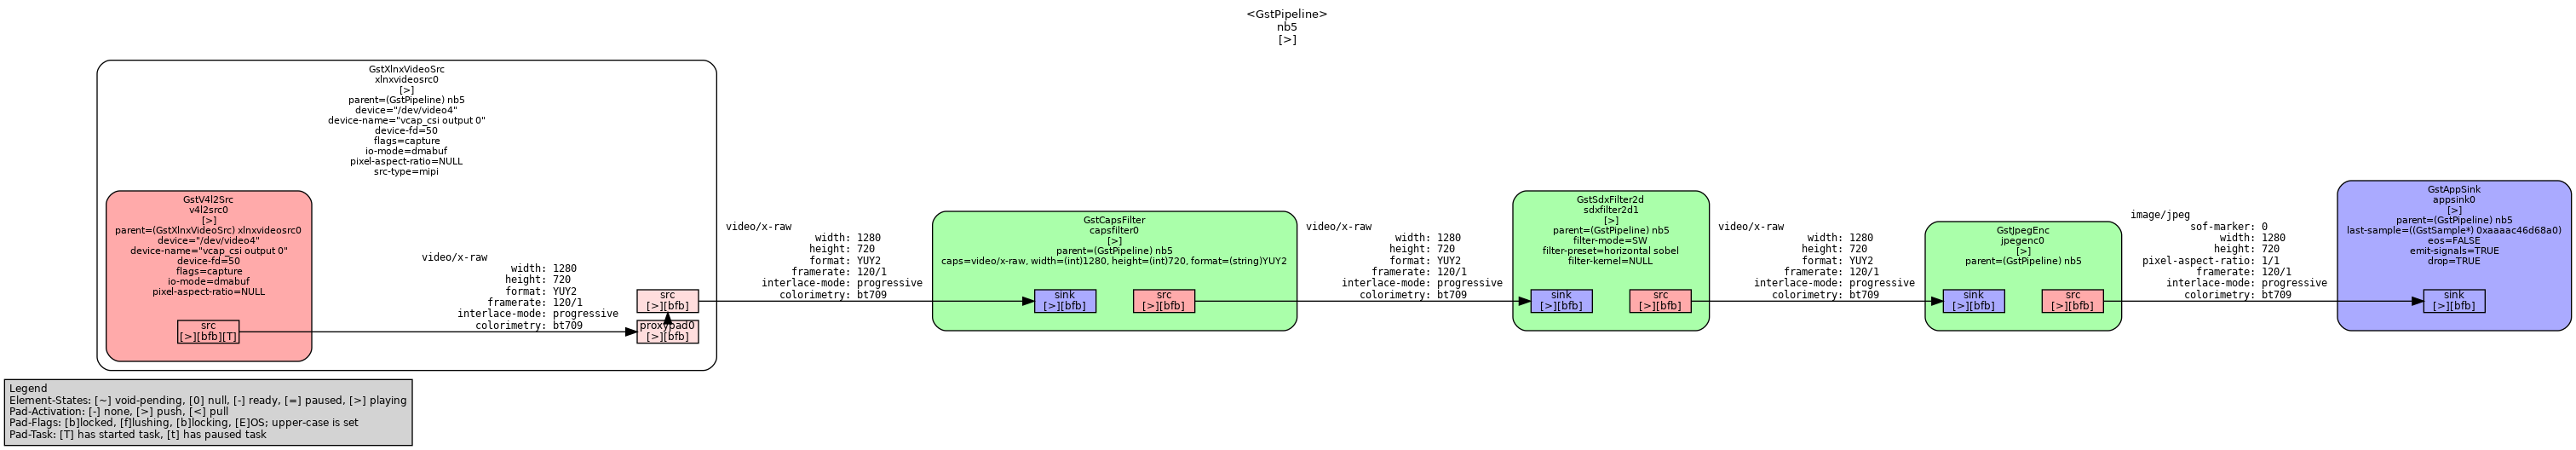

In [20]:
dotfile = dotdir + "/" + nb + ".dot"
graph = pydot.graph_from_dot_file(dotfile, 'utf-8')
display(Image(graph[0].create(None, 'png', 'utf-8')))

# 6. Summary

In this notebook you learned how to:
1. Create a GStreamer pipeline that demonstrates how to capture video from a V4L2 device, process the video using a 2D convolution filter, and play it back inside the jupyter notebook
2. Configure the 2D filter for different implementation modes: PS or PL
3. Program the filter coefficients directly or via presets
4. Export the pipeline topology as a dot file image and display it in the notebook

<center>Copyright© 2019 Xilinx</center>